In [1]:
#libraries
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parents[0]) 

In [2]:
pwd

'/mnt/c/Users/maxpu/Dropbox/scripts/Projects/abstraction'

In [3]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
# from STOMPnet import STOMPnet,Decoder
# from STOMPnet2 import STOMPnet2
# from utils import MultiChannelNet, get_width, count_parameters
from models import get_width, STOMP,MLP_baseline,sharedMLP_baseline
from types import SimpleNamespace
# import h5py
# import yaml
# import json
# import hashlib
# import wandb

In [4]:
model_names = ['STOMP','MLP','sharedMLP']
Nvec=[1e1,1e2,1e3,1e4]
Pvec= [1e6,1e7,1e8,1e9]
df=pd.DataFrame(columns=('model_name','P','N','width','Pactual'))
for mit,model_name in enumerate(model_names):
    for num_paras in Pvec:
        config = {
            'M_model': 1,
            'seq_len': 16,
            'P': num_paras,
            'batch_size': 8,
            'state_dim': 8,
            'num_actions':2,
            }
        if model_name=='STOMP':
            config['decoder_type'] = 'MLP'
            config['cross_talk'] = True
        else:
            config['decoder_type'] = 'BuffAtt'
            config['cross_talk'] = False
        config['model_name'] = model_name 
        config = SimpleNamespace(**config)
        Wvec=[]
        for N in Nvec:
            config.num_agents=int(N)
            if config.model_name=='STOMP':
                model = STOMP(config)
            elif config.model_name=='MLP':
                model = MLP_baseline(config)
            elif config.model_name =='sharedMLP':
                model = sharedMLP_baseline(config)
            Wvec.append(model.W)        
            P_actual = model.count_parameters()
            df=pd.concat([df,pd.DataFrame([{
                            'model_name':model_name,
                            'P':np.log10(config.P),
                            'N':N,
                            'width':model.W,
                            'Pactual':P_actual
                        }])],ignore_index=True)

enc_hidden/enc_out dims: 74/74
enc_hidden/enc_out dims: 74/74
enc_hidden/enc_out dims: 74/74
enc_hidden/enc_out dims: 74/74
enc_hidden/enc_out dims: 598/598
enc_hidden/enc_out dims: 598/598
enc_hidden/enc_out dims: 598/598
enc_hidden/enc_out dims: 598/598
enc_hidden/enc_out dims: 2257/2257
enc_hidden/enc_out dims: 2257/2257
enc_hidden/enc_out dims: 2257/2257
enc_hidden/enc_out dims: 2257/2257
enc_hidden/enc_out dims: 7501/7501
enc_hidden/enc_out dims: 7501/7501
enc_hidden/enc_out dims: 7501/7501
enc_hidden/enc_out dims: 7501/7501


Validation

In [5]:
import seaborn as sns

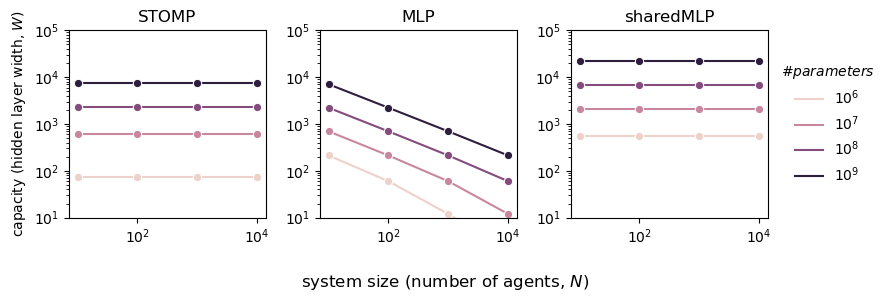

In [8]:
fig,ax=pl.subplots(1,len(model_names),figsize=(3*len(model_names),3))

for mit,model_name in enumerate(model_names):
    
#     ,label="{:.2e}".format(num_paras)
    sns.lineplot(data=df.loc[df['model_name']==model_name],
                    ax=ax[mit],
                    x='N',
                    y='width',
                    hue='P',
                    marker='o',
                    legend=False if mit<2 else True)
    if mit>0:
        ax[mit].set_ylabel(None)
    ax[mit].set_xlabel(None)
    ax[mit].set_yscale('log')
    ax[mit].set_xscale('log')
    ax[mit].set_ylim(1e1,1e5)
    ax[mit].set_title(model_name)
# ax[1].plot(np.logspace(1,4,10),10*np.logspace(1,4,10)[::-1]**(1/2))
ax[0].set_ylabel('capacity (hidden layer width, $W$)')
h, l = ax[len(model_names)-1].get_legend_handles_labels()
ax[len(model_names)-1].legend(h,[r"$10^"+string[0]+r"$" for string in l],frameon=False,title=r'$\# parameters$',loc='center left', bbox_to_anchor=(1, 0.5))  
fig.supxlabel(r'system size (number of agents, $N$)')
fig.tight_layout()

Text(0.5, 1.0, '$(\\epsilon,\\delta)=(10^{-2},10^{-2})$ PAC lower bound')

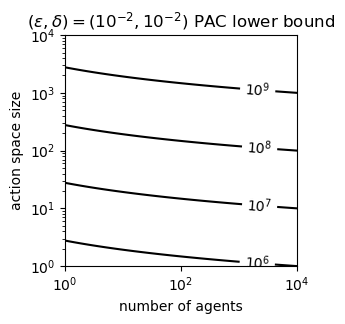

In [164]:
import matplotlib.ticker as ticker
fig,ax=pl.subplots(figsize=(3,3))
action_space_size=np.logspace(0,4,300)
Nvec=np.logspace(0,4,100)
X, Y = np.meshgrid(Nvec, action_space_size)
eps=0.01
delta=0.01
Z=np.log10(Y*(4-16*np.log10(1-(1-delta)**(1/X)))/eps**2)
ax.set_xscale('log')
ax.set_yscale('log')
levels=np.arange(6,11,1)
CS = pl.contour(X, 
                Y, 
                Z, 
                levels,
                extent=[X[0], X[-1], Y[0], Y[-1]],
                colors='black'
               )
fmt = {}
strs = [r'$10^{'+str(x)+'}$' for x in levels]
for l, s in zip(CS.levels, strs):
    fmt[l] = s

# Label every other level using strings
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

# pl.imshow(Z, origin='lower',
#            cmap='RdGy', alpha=0.5)
# cbar=pl.colorbar();
# cbar.ax.set_ylabel('# of joint actions')#, rotation=270)
# cbar.ax.get_yaxis().set_ticks([])
ax.set_xlabel('number of agents')
ax.set_ylabel('action space size')
ax.set_title(r'$(\epsilon,\delta)=(10^{-2},10^{-2})$ PAC lower bound')